# SVM

In [1]:
import torch
import numpy as np
from ASLDataset import ASLDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection  import cross_val_score
from torchvision import transforms as tf

MAX_IMGS = 100

def plot_confusion_matrix(y_pred, y):
    cm = confusion_matrix(y_true=y, y_pred=y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

def report(y, y_pred):
    err = 0
    for n, y_true in enumerate(y):
        if y_true != y_pred[n]:
            err += 1
    N = len(y)
    acc = 1 - err / N
    f1 = f1_score(y, y_pred, average='macro')
    print("error: %d total: %d" % (err, N))
    print("accuracy rate: %.2f %%" % (acc * 100))
    print("F1-score: %.2f" % f1)
    cm = plot_confusion_matrix(y, y_pred)
    return (err, acc, f1, cm, N)


def plot_3_examples(imgs, features, lables):
    if features.shape[1] != 200:
        features = features[:,0,:,:]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    ax = axes.ravel()
    for i, img in enumerate(imgs):
        ax[i].imshow(features[img])
        ax[i].set_title(lables[img])
    fig.tight_layout()
    plt.show()

def get_X_y_from(trainloader, testloader):

    for _, data in enumerate(trainloader, 0):
        X, y = data[0].numpy(), data[1].numpy()
        print("Trainingset features: \t", X.shape)
        print("Trainingset labels: \t", y.shape)

    for _, data in enumerate(testloader, 0):
        X_test, y_test = data[0].numpy(), data[1].numpy()
        print("Testset features: \t", X_test.shape)
        print("Testset labels: \t", y_test.shape)

    class _Data:

        def __init__(self, X, y, X_test, y_test):
            self.X = X
            self.y = y
            self.X_test = X_test
            self.y_test = y_test
            self.X_flt = self._flt(X)
            self.X_test_flt = self._flt(X_test)

        def _flt(self, data):
            new_size = 1
            for s in data.shape[1:]:
                new_size *= s
            return data.reshape([data.shape[0], new_size])

    return _Data(X, y, X_test, y_test)
    

### General SVM Workflow

In [2]:
def cross_validation_work(args, get_clf, X, y, cv=10, log=True):
    SVM_err = []
    for i, arg in enumerate(args):
        clf = get_clf(i, arg)
        scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        err = 1 - scores.mean()
        if log:
            print(arg, ' with error: ', err)
        SVM_err.append(err)
    return args[np.argmin(SVM_err)]


def svm_workflow(Dataset=ASLDataset, transforms=None, plot_examples=True, cv=False):
    # data preprocessing
    trainset = Dataset('train', transform=transforms, size_per_class=MAX_IMGS)
    testset = Dataset('test', transform=transforms, size_per_class=MAX_IMGS)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=trainset.__len__(), num_workers=10)
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.__len__(), num_workers=10)
    data = get_X_y_from(trainloader, testloader)
    
    # init data
    y = data.y
    y_test = data.y_test
    X = data.X_flt
    X_test = data.X_test_flt
    svm_generator = lambda i, arg: SVC(gamma='auto', kernel='rbf', decision_function_shape='ovr', C=arg)

    if plot_examples:
        plot_3_examples([0, 500, 1000], data.X, data.y)

    # cross validation
    opt_c = 20
    if cv:
        args = [i for i in range(20, 24)]
        opt_c = cross_validation_work(args, svm_generator, X, y)
        print('opt c ', opt_c)

    # training
    svm = svm_generator(0, opt_c)
    svm.fit(X, y)

    # test
    y_pred = svm.predict(X_test)
    
    return report(y_test, y_pred)
    
    

### Without Preprocessing

Trainingset features: 	 (2465, 200, 200, 3)
Trainingset labels: 	 (2465,)
Testset features: 	 (464, 200, 200, 3)
Testset labels: 	 (464,)


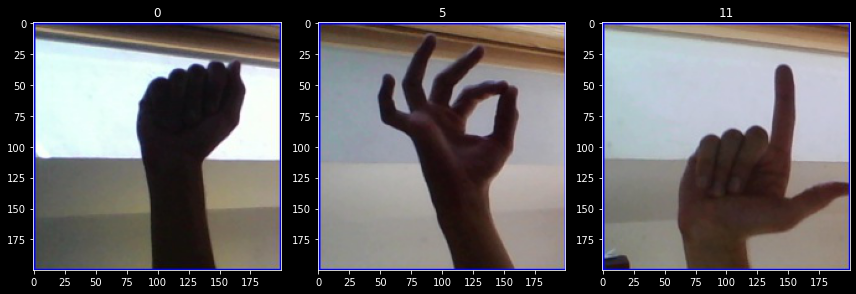

error: 448 total: 464
accuracy rate: 3.45 %
F1-score: 0.00


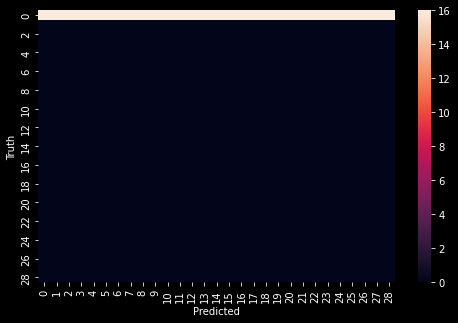

In [3]:
report_without_preprocessing = svm_workflow()

### Using Normalize Preprocessing

Trainingset features: 	 (2465, 3, 200, 200)
Trainingset labels: 	 (2465,)
Testset features: 	 (464, 3, 200, 200)
Testset labels: 	 (464,)


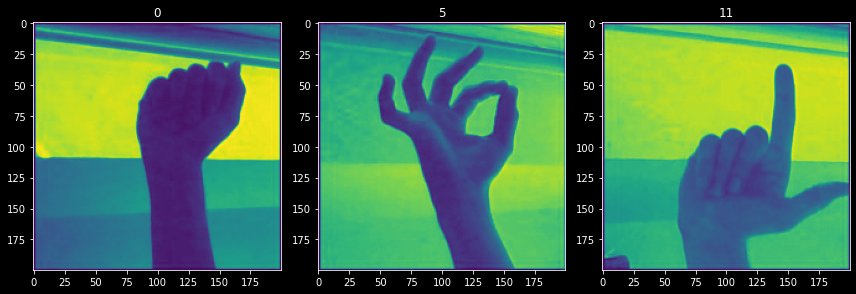

error: 102 total: 464
accuracy rate: 78.02 %
F1-score: 0.76


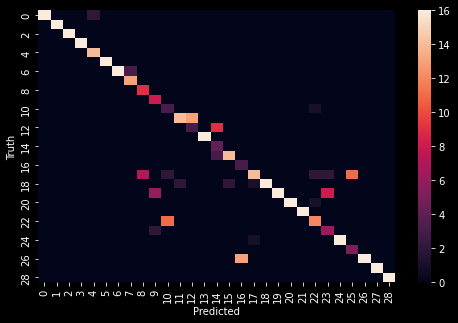

In [4]:
tf_normalize = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(0.5, 0.5)
])

report_normalize = svm_workflow(transforms=tf_normalize)

### Using Grayscale Preprocessing

Trainingset features: 	 (2465, 1, 200, 200)
Trainingset labels: 	 (2465,)
Testset features: 	 (464, 1, 200, 200)
Testset labels: 	 (464,)


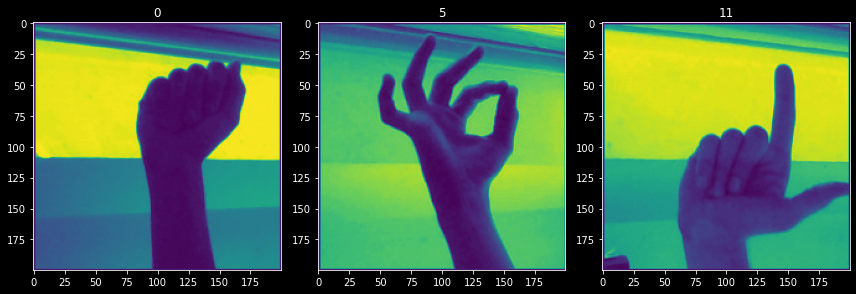

error: 135 total: 464
accuracy rate: 70.91 %
F1-score: 0.69


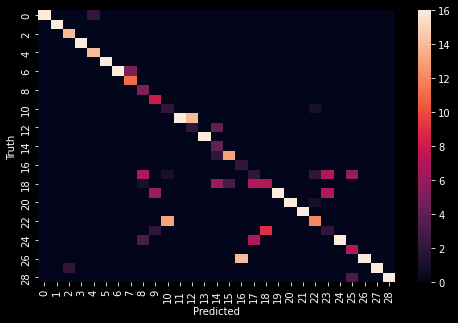

In [5]:
tf_grayscale = tf.Compose([
    tf.ToTensor(),
    tf.Grayscale(1)
])

report_grayscale = svm_workflow(transforms=tf_grayscale)

### Gray and Normalize

Trainingset features: 	 (2465, 1, 200, 200)
Trainingset labels: 	 (2465,)
Testset features: 	 (464, 1, 200, 200)
Testset labels: 	 (464,)


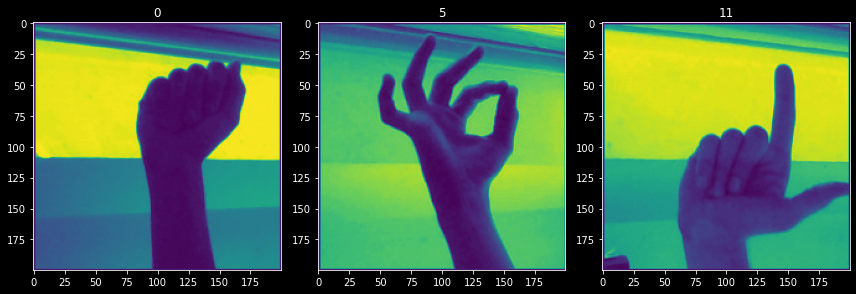

error: 107 total: 464
accuracy rate: 76.94 %
F1-score: 0.75


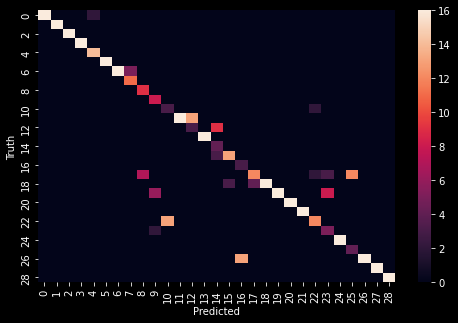

In [6]:
tf_gray_nor = tf.Compose([
    tf.ToTensor(),
    tf.Grayscale(1),
    tf.Normalize(0.5, 0.5)
])

report_gray_nor = svm_workflow(transforms=tf_gray_nor)